In [1]:
!pip install mmh3

In [2]:
%matplotlib inline
import numpy as np
from numpy import random
from math import log, e
from collections import Counter
import mmh3
import matplotlib.pyplot as plt

### **Data Generation**

In [3]:
# data generation parameter
stream_length = 1000

In [4]:
# generate data from uniform dist (random integers, this will show worst-case accuracy)
def gen_unif(stream_length):
	unif = random.randint(-5000,5000,stream_length)
	return(unif)

In [5]:
# generate integers from normal dist with high variance (this will show best case, when items that aren't counted are infrequent)
def gen_norm(stream_length):	
	norm = random.normal(0,1000,stream_length).astype(int)
	return(norm)

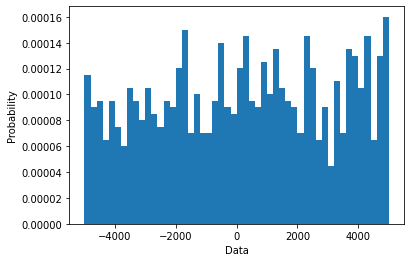

In [6]:
## generate random data
data_unif = gen_unif(stream_length)

plt.hist(data_unif, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

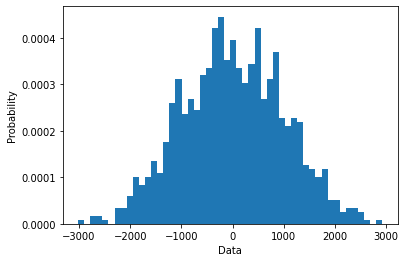

In [7]:
data_norm = gen_norm(stream_length)

plt.hist(data_norm, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [8]:
def rand_skew_norm(fAlpha, fLocation, fScale):
    sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1*fScale + fLocation 
    return (-u1)*fScale + fLocation 

def randn_skew(N, skew=0.0):
    return [rand_skew_norm(skew, 0, 1) for x in range(N)]

In [9]:
data_sample_skewed_1 = randn_skew(stream_length, 0.7)
data_sample_skewed_2 = randn_skew(stream_length, 3.0)

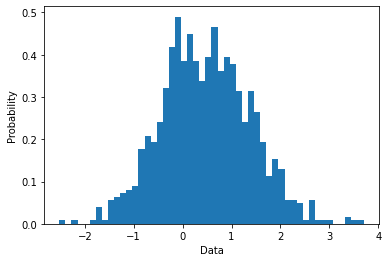

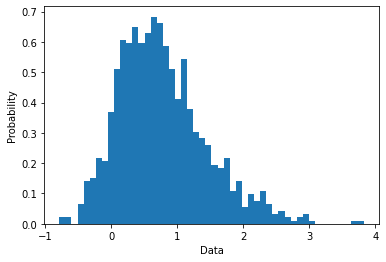

In [10]:
plt.hist(data_sample_skewed_1, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

plt.hist(data_sample_skewed_2, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [12]:
# fixed probability distribution
logit = random.normal(0, 1, 10000)
prob = softmax(logit)
population = list(range(-5000, 5000))
data_sample = np.random.choice(a = np.array(population), size = stream_length, replace = True, p = prob)


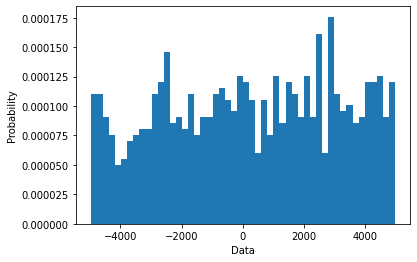

In [13]:
plt.hist(data_sample, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [14]:
# fixed squared probability distribution
prob_square = np.square(prob)
prob_square = softmax(prob_square)
data_sample_square = np.random.choice(a = np.array(population), size = stream_length, replace = True, p = prob_square)

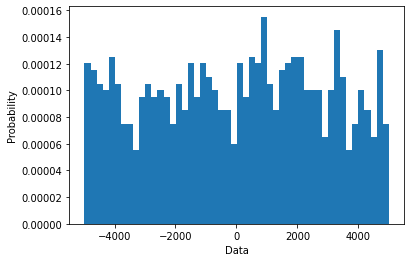

In [15]:
plt.hist(data_sample_square, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [16]:
# fixed square root probability distribution
prob_sqrt = np.sqrt(prob)
prob_sqrt = softmax(prob_sqrt)
data_sample_sqrt = np.random.choice(a = np.array(population), size = stream_length, replace = True, p = prob_sqrt)

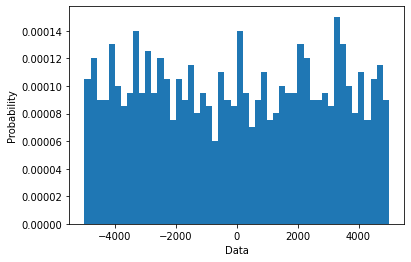

In [17]:
plt.hist(data_sample_sqrt, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

In [18]:
# fixed probability distribution (gamma distribution)
data_sample_gamma_1 = random.gamma(1, 2, stream_length).astype(int)
data_sample_gamma_2 = random.gamma(2, 2, stream_length).astype(int)


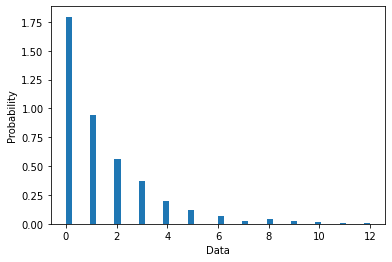

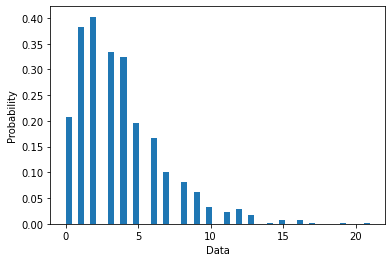

In [19]:
plt.hist(data_sample_gamma_1, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

plt.hist(data_sample_gamma_2, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

### **Frequent Count Algorithms**
1. Misra-Gries
2. Space-saving
3. Count-min


In [20]:
# frequency count algorithms parameter
num_counters = 10

In [21]:
def get_frequencies(data):
	unique, counts = np.unique(data,return_counts=True)
	frequencies = list(zip(unique,counts))
	return(frequencies,len(unique))

In [22]:
# calculate error for each items
def get_errors(counters,frequencies):
	items = [t[0] for t in frequencies]
	counted = list()
	for key in list(counters.keys()):
		counted.append(key)
	uncounted = [item for item in items if item not in counted]
	errors = Counter()
	## errors for items that don't have counters are their actual frequencies
	for item in uncounted:
		errors[item]+=[t[1] for t in frequencies if t[0] == item][0]
	for item in counted:
		errors[item]+=[t[1] for t in frequencies if t[0] == item][0]-counters[item]
		return(errors)

In [23]:
# maximum error should be less than m/k 
def test_errors(errors,stream_length,num_counters):
    flag = True
    for error in errors.values():
        if (error < stream_length/num_counters):
            continue
        else:
            flag = False
            break
    if flag:
        print('All errors are smaller than m/k = ' + str(stream_length/num_counters))

### **Misra-Gries**
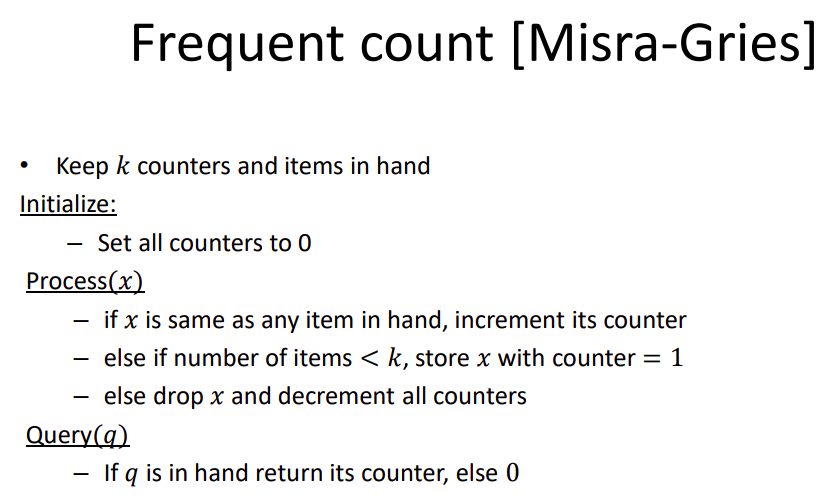

In [24]:
def misra_gries(stream, k):
    counters = Counter()
    for item in stream:
        ## case 1: item already has counter or there are empty counters
        if item in counters or len(counters) < k:
            counters[item] += 1
        ## case 2: item doesn't have counter and there are no empty counters
        else:
            for key in list(counters.keys()):
                counters[key] -= 1
                if counters[key] == 0:
                    del counters[key]
    return counters

In [25]:
## run MG on data
out_mg = misra_gries(data_sample_gamma_1,int(num_counters))
print(out_mg)

search_item = 1
try:
	estimate = out_mg[search_item]
except:
	estimate = 0
print("The estimated frequency of item " + str(search_item) + " is: " + str(estimate))

Counter({0: 427, 1: 222, 2: 131, 3: 85, 4: 44, 5: 25, 6: 13, 8: 6, 7: 2, 9: 1})
The estimated frequency of item 1 is: 222


In [26]:
# performance analysis
frequencies = get_frequencies(data_sample_gamma_1)
print(frequencies)
errors = get_errors(out_mg,frequencies[0])
test_errors(errors,stream_length,num_counters)

([(0, 431), (1, 226), (2, 135), (3, 89), (4, 48), (5, 29), (6, 17), (7, 6), (8, 9), (9, 5), (10, 3), (11, 1), (12, 1)], 13)
All errors are smaller than m/k = 100.0


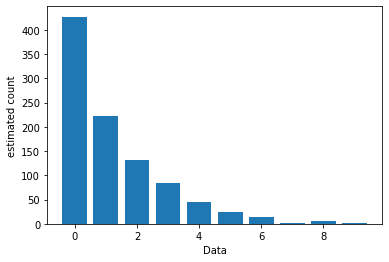

In [27]:
plt.bar(out_mg.keys(), out_mg.values())
plt.ylabel('estimated count')
plt.xlabel('Data')
plt.show()


### **Space saving**
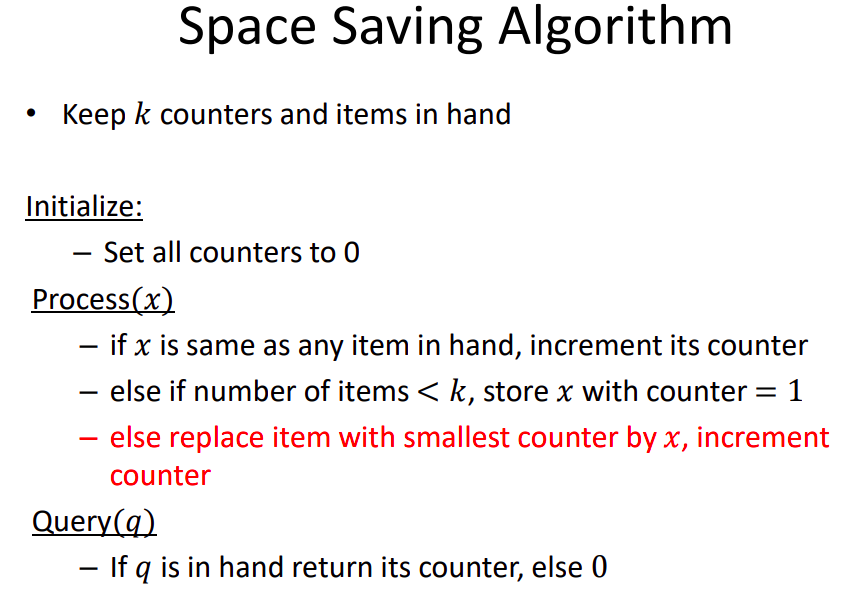

In [28]:
def space_saving(stream, k):
    counters = Counter()
    for item in stream:
        ## case 1: item already has counter or there are empty counters
        if item in counters or len(counters) < k:
            counters[item] += 1
        ## case 2: item doesn't have counter and there are no empty counters
        else:
            min_key = min(counters, key = counters.get)
            counters[min_key] += 1
            counters[item] = counters.pop(min_key)
    return counters

In [29]:
## run space-saving on data
#data = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 6], dtype = np.int32)
out_ss = space_saving(data_sample_gamma_1,int(num_counters))
print(out_ss)
search_item = 5
try:
	estimate = out_ss[search_item]
except:
	estimate = 0
print("The estimated frequency of item " + str(search_item) + " is: " + str(estimate))

Counter({0: 431, 1: 226, 2: 135, 3: 89, 4: 48, 5: 29, 6: 17, 8: 11, 9: 7, 7: 7})
The estimated frequency of item 5 is: 29


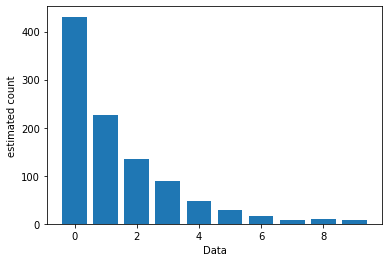

In [30]:
plt.bar(out_ss.keys(), out_ss.values())
plt.ylabel('estimated count')
plt.xlabel('Data')
plt.show()

### **Count-min sketch**
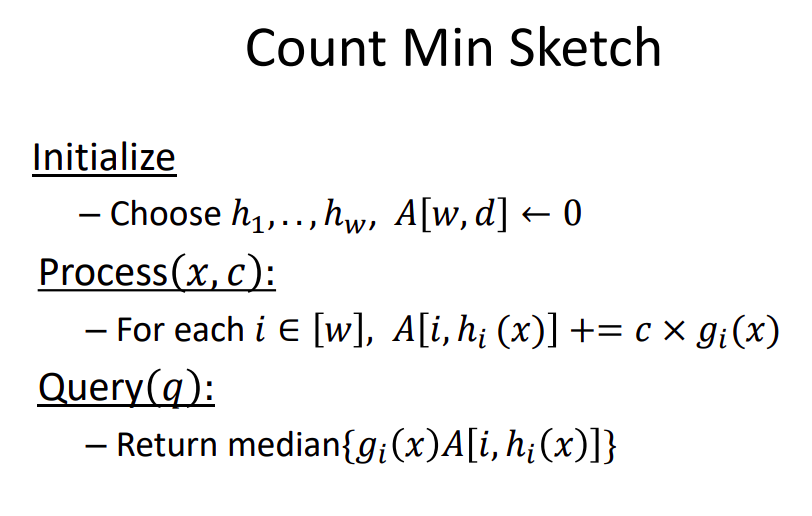 

In [31]:
class CountMinSketch(object):
    ''' Class for a CountMinSketch data structure
    '''
    def __init__(self, width, depth, seeds):
        ''' Method to initialize the data structure
        @param width int: Width of the table
        @param depth int: Depth of the table (num of hash func)
        @param seeds list: Random seed list
        '''
        self.width = width
        self.depth = depth
        self.table = np.zeros([depth, width])  # Create empty table
        self.seed = seeds # np.random.randint(w, size = d) // create some seeds

    def increment(self, key):
        ''' Method to add a key to the CMS
        @param key str: A string to add to the CMS
        '''
        for i in range(0, self.depth):
            index = mmh3.hash(key, self.seed[i]) % self.width
            self.table[i, index] = self.table[i, index]+1

    def estimate(self, key, stream_len):
        ''' Method to estimate if a key is in a CMS
        @param key str: A string to check
        '''
        min_est = stream_len + 1
        for i in range(0, self.depth):
            index = mmh3.hash(key, self.seed[i]) % self.width
            if self.table[i, index] < min_est:
                min_est = self.table[i, index]
        return min_est

[[  0.   0.   0.   0.   0. 431. 135.   0.   9.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0. 226.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.  17.   0.   0.   0.   0.
    0.   0.   0.  48.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
    0.   0.   0.   0.   0.   0.  29.   0.   0.   0.   0.   0.   0.  89.
    0.   0.   0.   0.   0.   0.   0.   0.   3.  11.   0.   0.   1.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  1.   0.   0.   0.   0.   0.   6.   0.   0.   9.   0.   0.   1.   0.
    0.   0.   0.   0.   3.   0. 226.   0.   0.   0.   0.  48.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.  29.   0.   0.   0.   0.   0.   0.   0. 135.   0.
    0.   0.  17.   0.   0.   0.  89.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

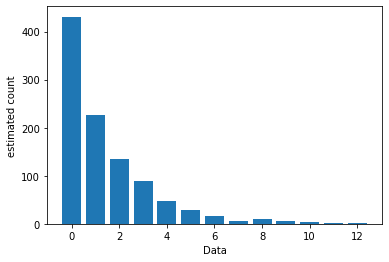

In [32]:
## run space-saving on data
#data = np.array([1, 2, 1, 1, 3, 2, 1, 1, 2, 3, 4, 2], dtype = np.int32)
param_w = 100
param_d = 10
seeds = np.random.randint(param_w, size = param_d)
cminsketch = CountMinSketch(param_w, param_d, seeds = seeds)
for item in data_sample_gamma_1:
  cminsketch.increment(str(item))
print(cminsketch.table)
search_item = 1
#try:
estimate = cminsketch.estimate(str(search_item), stream_length)
#except:
#  estimate = 0
print("The estimated frequency of item " + str(search_item) + " is: " + str(estimate))

estimate_dict = {}
for item in data_sample_gamma_1:
  if item not in estimate_dict:
    estimate_dict[item] =  cminsketch.estimate(str(item), stream_length)

plt.bar(estimate_dict.keys(), estimate_dict.values())
plt.ylabel('estimated count')
plt.xlabel('Data')
plt.show()

**Plot accuracy of these frequent count algorithms on the above generated streams w.r.t. respective distribution entropy**

# Entropy calculation

In [33]:
def entropy(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = e if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

# Error Calculation

In [79]:
def get_error_top10(original_counter, calculated_counter):
  size = int(0.1 * len(original_counter))

  if size == 0:
    size = 1

  items = original_counter.most_common(size)

  res = 0
  for item in items:
    calc = calculated_counter.get(item[0])
    if not calc:
      calc = 0
    res += abs(item[1]-calc)/item[1]

  return res/size

# Misra Gries

### Normal Distribution

In [80]:
x = []
y = []

for scale in range(100, 501, 5):
  normal = random.normal(0.0, scale, stream_length).astype(int)
  out_mg = misra_gries(normal, 10)
  x.append(entropy(normal))
  y.append(get_error_top10(Counter(normal), out_mg))

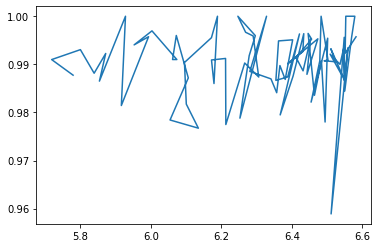

In [81]:
plt.plot(x, y)

### Gamma Distribution

In [82]:
x = []
y = []

for scale in range(100, 501, 5):
  gamma = random.gamma(2, scale, stream_length).astype(int)
  out_mg = misra_gries(gamma, 10)
  x.append(entropy(gamma))
  y.append(get_error_top10(Counter(gamma), out_mg))

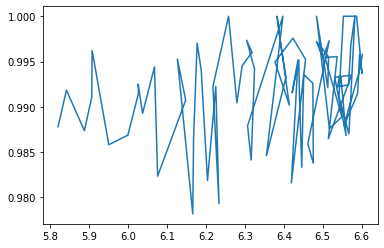

In [83]:
plt.plot(x, y)

# Space Saving

### Normal Distribution

In [84]:
x = []
y = []

for scale in range(100, 501, 5):
  normal = random.normal(0.0, scale, stream_length).astype(int)
  out_mg = space_saving(normal, 10)
  x.append(entropy(normal))
  y.append(get_error_top10(Counter(normal), out_mg))

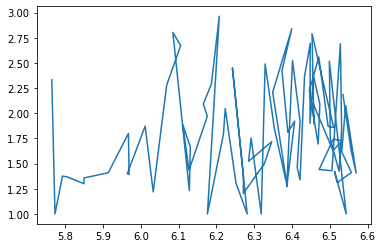

In [85]:
plt.plot(x, y)

### Gamma Distribution

In [86]:
x = []
y = []

for scale in range(100, 501, 5):
  gamma = random.gamma(2, scale, stream_length).astype(int)
  out_mg = space_saving(gamma, 10)
  x.append(entropy(gamma))
  y.append(get_error_top10(Counter(gamma), out_mg))

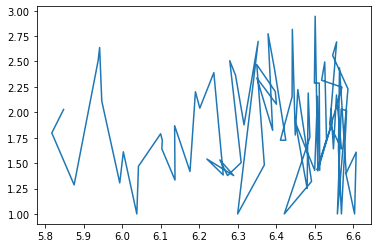

In [87]:
plt.plot(x, y)

# Count Min

### Normal Distribution

In [88]:
x = []
y = []

for scale in range(100, 501, 5):
  normal = random.normal(0.0, scale, stream_length).astype(int)
  cminsketch = CountMinSketch(scale, 10, seeds=normal)

  for item in normal:
    cminsketch.increment(str(item))

  estimate_dict = {}
  for item in normal:
    if item not in estimate_dict:
      estimate_dict[item] =  cminsketch.estimate(str(item), stream_length)

  x.append(entropy(normal))
  y.append(get_error_top10(Counter(normal), estimate_dict))

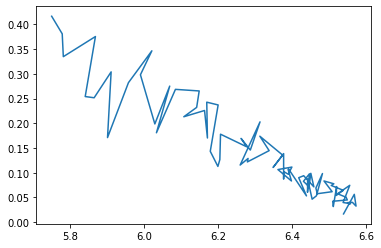

In [89]:
plt.plot(x, y)

### Gamma Distribution

In [90]:
x = []
y = []

for scale in range(100, 501, 5):
  gamma = random.gamma(2, scale, stream_length).astype(int)
  cminsketch = CountMinSketch(scale, 10, seeds=gamma)

  for item in gamma:
    cminsketch.increment(str(item))

  estimate_dict = {}
  for item in gamma:
    if item not in estimate_dict:
      estimate_dict[item] =  cminsketch.estimate(str(item), stream_length)

  x.append(entropy(gamma))
  y.append(get_error_top10(Counter(gamma), estimate_dict))

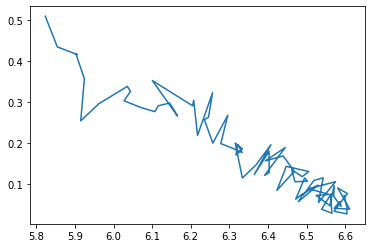

In [91]:
plt.plot(x, y)